In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import time
import os
import json
from base64 import b64decode
from io import BytesIO
from PIL import Image
from multiprocessing import Pool
from IPython.display import display
import gc
import pickle
from tensorflow.keras.utils import pad_sequences
import re
from tensorflow.keras.utils import to_categorical

2023-03-01 23:50:44.740270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 23:50:45.926648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/cudnn-8.2.4.15-11.4-eluwegpwn6adr7hlku5p5wru5xzefpop/lib64:/hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/cuda-11.4.4-ctldo35wmmwws3jbgwkgjjcjawddu3qz/lib64:/hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/neovim-0.7.0-terkir3wk5rst6ktv4uxyaqjditacv5p/lib
2023-03-01 23:50:45.926731: W tensorflow/compiler/xla/stream_execut

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# eager execution
tf.compat.v1.enable_eager_execution()

### Constants

In [3]:
DATA_FOLDER = '/work/users/skoka/Data/WikipediaImageCaptionsProccessed/'
PICKLE_DIRECTORY = "/work/users/skoka/Data/WikipediaImageCaptionsPickles/"
TARGET_LANGUAGES = ['en', 'es', 'fr']

In [4]:
# lists all .json files in the data folder
files = [f for f in os.listdir(DATA_FOLDER) if f.endswith('.json')]
files.sort()
pickles = [f for f in os.listdir(PICKLE_DIRECTORY + "processed_data") if f.endswith('.pickle')]
pickles.sort()

In [5]:
# each json file has multiple json documents so we need to split them before loading
def load_file_into_json(file):
    with open(file) as f:
        json_list = [json.loads(line) for line in f.read().splitlines()]
    return json_list

### Processing Data into the format shown below:

[
    {
        "image": "numpy array of image", 
        "captions": {
            "en" : "the caption",
            "es" : "el caption",
            ....
        }
    }
]


This code will then dump all the data into pickle files for later usage.

In [6]:
def _image_bytes_to_numpy(image_bytes):
    image_decoded = b64decode(image_bytes)
    image = Image.open(BytesIO(image_decoded)).convert("RGB") # Opens image from the decoded bytes
    image = image.resize((250, 250)) # Resizes all images to 250x250 to remain consistent
    image = np.array(image) # Converts image to numpy array
    return image

# Gets the captions for the targeted languages if they exist
def _process_captions(captions):
    processed_captions = {}
    for caption in captions:
        if caption['language'] in TARGET_LANGUAGES:
            # Sometimes the caption is non existent so we need to catch the error
            try:
                processed_captions[caption['language']] = caption['caption_reference_description']
            except:
                continue
    return processed_captions

def process_data(json_list):
    data = []
    for json_doc in json_list:
        image = _image_bytes_to_numpy(json_doc['b64_bytes'])
        captions = _process_captions(json_doc['wit_features'])
        curr_data = {
            'image': image,
            'captions': captions
        }
        data.append(curr_data)
    return data
def load_data_from_pickle(pickle_file):
    with open(PICKLE_DIRECTORY + "processed_data/" + pickle_file, 'rb') as f:
        data = pickle.load(f)
    return data

### Processing Data to use in English only caption generation:

In [7]:
from keras.preprocessing.text import Tokenizer
with open(PICKLE_DIRECTORY + "captions.pickle", "rb") as f:
    captions = pickle.load(f)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
tokenizer.word_index['<STAAART>'] = vocab_size
tokenizer.word_index['<ENDDD>'] = vocab_size + 1
vocab_size += 2
word_index = tokenizer.word_index

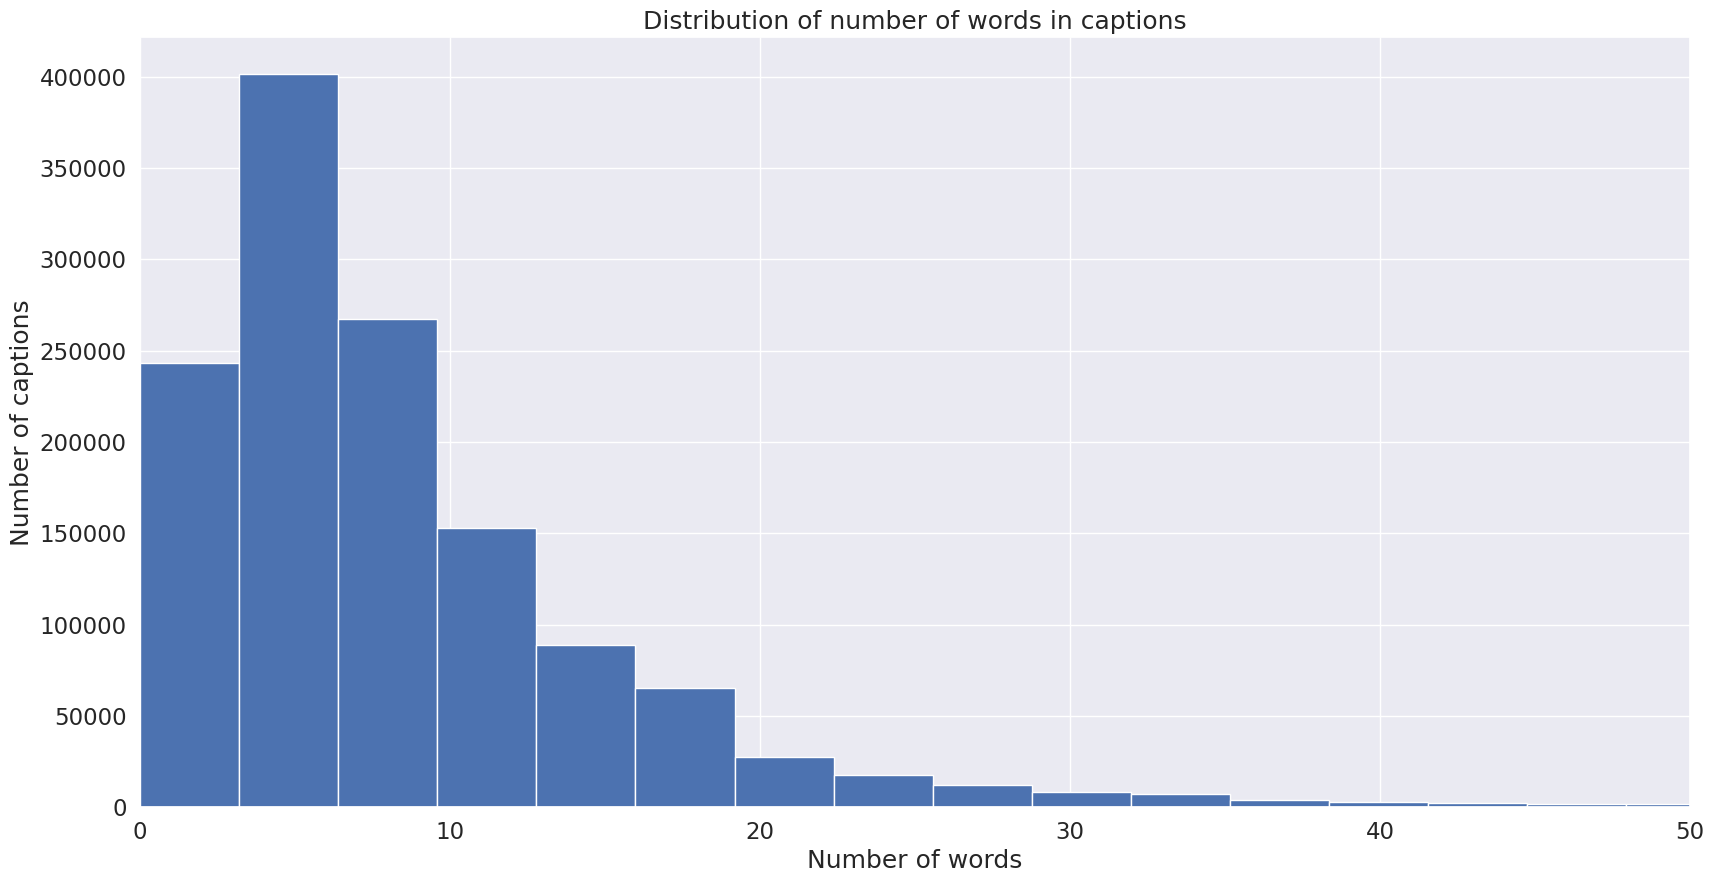

In [8]:
# plot a distribution of the number of words in the captions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

def plot_distribution(data, title):
    plt.hist(data, bins=300)
    plt.title(title)
    plt.xlabel("Number of words")
    plt.ylabel("Number of captions")
    # cut the x axis to 50 words
    plt.xlim(0, 50)
    plt.show()

plot_distribution([len(caption.split()) for caption in captions], "Distribution of number of words in captions")

In [9]:
def load_embeddings(filename, embed_size):
    # the embed size should match the file you load glove from
    embeddings_index = {}
    f = open(filename)
    # save key/array pairs of the embeddings
    #  the key of the dictionary is the word, the array is the embedding
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))

    # now fill in the matrix, using the ordering from the
    #  keras word tokenizer from before
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be ALL-ZEROS
            embedding_matrix[i] = embedding_vector
            found_words = found_words+1

    print("Embedding Shape:",embedding_matrix.shape, "\n",
        "Total words found:",found_words, "\n",
        "Percentage:",100*found_words/embedding_matrix.shape[0])
    return embedding_matrix

embedding_matrix = load_embeddings("/users/skoka/Documents/ML-Lab2-Multi-Modal/numberbatch-en-19.08.txt", 300)

Found 516783 word vectors.
Embedding Shape: (593724, 300) 
 Total words found: 117451 
 Percentage: 19.782087299822813


In [10]:
MAX_CAPTION_LENGTH = 25
# Create a data generator to load the data in batches to avoid memory issues
# Only for English captions
def clean_caption(caption):
    caption = caption.lower()
    # remove non alphanumeric characters
    caption = re.sub(r'[^a-zA-Z0-9\s]', '', caption)
    # add start and end tokens
    caption = '<STAAART> ' + caption + ' <ENDDD>'
    return caption

def data_generator(batch_size=32):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for pickle_file in pickles:
            data = load_data_from_pickle(pickle_file)
            for doc in data:
                image = doc['image']
                captions = doc['captions']
                if 'en' in captions:
                    caption = captions['en']
                    caption = clean_caption(caption)
                    caption = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(caption)):
                        in_seq, out_seq = caption[:i], caption[i]
                        in_seq = pad_sequences([in_seq], maxlen=MAX_CAPTION_LENGTH)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(image)
                        X2.append(in_seq)
                        y.append(out_seq)
                        n += 1
                        if n == batch_size:
                            yield [np.array(X1), np.array(X2)], np.array(y)
                            X1, X2, y = [], [], []
                            n = 0

In [11]:

# Build a VGG model that takes input of size 250x250x3
vgg = tf.keras.applications.VGG19(input_shape=(250, 250, 3), include_top=False, weights='imagenet')

# remove the last layer of the VGG model
vgg = tf.keras.Model(inputs=vgg.inputs, outputs=vgg.layers[-2].output)
vgg.trainable = False

image_dense = tf.keras.layers.Flatten()(vgg.output)
image_dense = tf.keras.layers.Dense(256, activation='relu')(image_dense)

# Build a LSTM model that takes input of size 25
caption_input = tf.keras.layers.Input(shape=(MAX_CAPTION_LENGTH,))
# caption_embedding = tf.keras.layers.Embedding(vocab_size, 50, mask_zero=True)(caption_input)
caption_embedding = tf.keras.layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False, input_length=MAX_CAPTION_LENGTH)(caption_input)
caption_lstm = tf.keras.layers.LSTM(256)(caption_embedding)


# Merge the two models
decoder1 = tf.keras.layers.add([image_dense, caption_lstm])
decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)

model = tf.keras.Model(inputs=[vgg.input, caption_input], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot model:
model.summary()


2023-03-01 23:51:33.371154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 23:51:37.764212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-01 23:51:37.768134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-01 23:51:37.771803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 250, 250, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 250, 250, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [12]:
generator = data_generator(batch_size=512)
model.fit_generator(generator, epochs=10, steps_per_epoch=80000, verbose=1)

/tmp/ipykernel_2091425/2479475474.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=10, steps_per_epoch=80000, verbose=1)


Epoch 1/10


2023-03-01 23:51:46.187833: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-03-01 23:51:47.099776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-01 23:51:55.144094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-01 23:51:55.188161: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efcb7169c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-01 23:51:55.188191: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-03-01 23:51:55.188199: I tensorflow/compiler/xla/service/service

   59/80000 [..............................] - ETA: 20:37:02 - loss: 10.2504

KeyboardInterrupt: 

In [ ]:
def predict_caption(model, image):
    in_text = '<STAAART>'
    for i in range(MAX_CAPTION_LENGTH):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=MAX_CAPTION_LENGTH)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        in_text += ' ' + word
        if word == '<ENDDD>':
            break
    return in_text

In [ ]:
generator = data_generator(batch_size=1)
for i in range(10):
    [image, seq], _ = next(generator)
    yhat = predict_caption(model, image)
    print(yhat)